<a href="https://colab.research.google.com/github/Mahonry/RedesNeuronales/blob/master/Proyecto_Precios_Vehiculos_Usados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![texto alternativo](https://drive.google.com/uc?id=1_ZoJOp39dxsRTVndJP1_7jdY7oGi8sSu) 

<h1><center>Redes Neuronales con Keras y Scikit</center></h1>


<center><i>Proyecto: Predicción de precios de vehiculos usados</i></center>

<h1>Contenido</h1>

<div class="alert alert-block alert-warning" style="margin-top: 20px">
    <ol>
        <li><a href="#problema">Contexto Analítico  y exploración de datos</a></li>     
        <li><a href="#ingenieria">Ingeniería de datos</a></li>           
        <li><a href="#arquitectura">Diseño, Entrenamiento y Evaluación de la RN</a></li>
    </ol>
</div>
<br>
<hr>

<h1 id="problema">Contexto analítico y exploración de datos</h1>

El mercado de autos usados es reconocido por ser un sector economico muy competido con un centenar de compañias que luchan por hacerse con una porción de la torta. El precio de los autos se devalua año año debido a multiples factores y determinar el precio correcto es clave para las compañias para lograr competir en el mercado. En este caso se requiere implementar una red neural que permita determinar el valor más justo para los vehiculos dependiento de sus atributos.

Se cuenta con un dataset (Craiglist_Cars.csv) que serán cargados directamente a Colab.


In [0]:
#Importamos las librerias necesarias
import pandas as pd
import numpy as np
import io
from google.colab import files #Librería necesaria para interactuar con archivos en Colab

In [0]:
#uploaded = files.upload()
#cars = pd.read_csv(io.StringIO(uploaded['Craiglist_Cars.csv'].decode('utf-8')), sep = ',' )
cars = pd.read_csv('Craiglist_Cars.csv', sep = ',' )
cars.head(3)

,year,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,price
0,2009,chevrolet,good,8 cylinders,gas,clean,automatic,rwd,full-size,SUV,white,9000
1,2002,gmc,good,8 cylinders,gas,clean,automatic,4wd,NaN,pickup,white,6000
2,2007,pontiac,excellent,4 cylinders,gas,clean,automatic,fwd,compact,convertible,red,7000


#1. Evalua la cantidad, tipo y completitud de las variables disponibles. 



In [0]:
print(cars.shape)
100*cars.isnull().sum()/cars.shape[0]

(434542, 12)


year             0.000000
manufacturer     3.646138
condition       36.860649
cylinders       28.306355
fuel             0.839505
title_status     0.662997
transmission     0.989087
drive           13.280189
size            58.133621
type            11.566661
paint_color     19.734571
price            0.000000
dtype: float64

In [0]:
types = pd.DataFrame(cars.dtypes)
print("Tipos de variables",types.groupby(0).size())

Tipos de variables 0
int64      2
object    10
dtype: int64


In [0]:
categoricas = types.index[types[0] == 'O'].values
for line in categoricas:
 print("La variable "+ line +" contiene:",str(len(cars[line].unique()))+" distinct values")

La variable manufacturer contiene: 43 distinct values
La variable condition contiene: 7 distinct values
La variable cylinders contiene: 9 distinct values
La variable fuel contiene: 6 distinct values
La variable title_status contiene: 7 distinct values
La variable transmission contiene: 4 distinct values
La variable drive contiene: 4 distinct values
La variable size contiene: 5 distinct values
La variable type contiene: 14 distinct values
La variable paint_color contiene: 13 distinct values


In [0]:
for i in categoricas:
    print("Distribución de ",i,": \n", 100*cars[i].value_counts()/cars.shape[0],"\n")

Distribución de  manufacturer : 
 ford               17.966273
chevrolet          14.873591
toyota              7.667383
nissan              5.094789
honda               5.086045
jeep                4.915060
ram                 4.827381
gmc                 4.297628
dodge               3.775699
bmw                 2.687887
hyundai             2.462133
subaru              2.127988
mercedes-benz       2.062401
volkswagen          2.023280
chrysler            1.783947
kia                 1.712378
cadillac            1.504343
buick               1.329906
lexus               1.304592
mazda               1.288023
audi                1.187917
acura               0.865509
infiniti            0.783814
pontiac             0.766784
lincoln             0.685319
volvo               0.590507
mitsubishi          0.550004
mini                0.441154
rover               0.433330
mercury             0.412848
saturn              0.377639
jaguar              0.226906
fiat                0.153265
harley-da

<h1 id="ingenieria">Ingeniería de datos</h1>

Ahora se debe preparar la información para poder alimentar la red neuronal.

# 2. Implementa estrategías para tratar la información nula en las variables cuya tasa de nulos sea máximo el 10%

In [0]:
#Reemplazamos el tipo de actividad por la moda 
cars["fuel"] = cars["fuel"].fillna(cars["fuel"].mode()[0])
cars["title_status"] = cars["title_status"].fillna(cars["title_status"].mode()[0])
cars["transmission"] = cars["transmission"].fillna(cars["transmission"].mode()[0])
cars["manufacturer"] = cars["manufacturer"].fillna(cars["manufacturer"].mode()[0])
#Verificamos el cambio
100*cars.isnull().sum()/cars.shape[0]

year             0.000000
manufacturer     0.000000
condition       36.860649
cylinders       28.306355
fuel             0.000000
title_status     0.000000
transmission     0.000000
drive           13.280189
size            58.133621
type            11.566661
paint_color     19.734571
price            0.000000
dtype: float64

Luego del procedimiento anterior se debe proceder a convertir las variables categoricas en variables numericas. Durante el curso implementamos un método de One Hot Encoding disponible en Scikit Learn. En este caso utilizaremos una funcionalidad embedida en Pandas denominada ["get_dummies"](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html):

In [0]:
df= cars.copy()
for col in categoricas:
    df = pd.concat([df, (pd.get_dummies(df[col])).astype(int)], axis=1)
    df.drop(columns=[col],inplace=True)
#Al crear las variables dummies se crean varias columnas referentes a categorias
# 'other' que no aportan ningún valor al dataset por lo cual las eliminamos
df.drop('other', axis=1, inplace=True)
print(df.shape)
df.head(3)

(434542, 100)


,year,price,acura,alfa-romeo,aston-martin,audi,bmw,buick,cadillac,chevrolet,chrysler,datsun,dodge,ferrari,fiat,ford,gmc,harley-davidson,hennessey,honda,hyundai,infiniti,jaguar,jeep,kia,land rover,lexus,lincoln,mazda,mercedes-benz,mercury,mini,mitsubishi,morgan,nissan,pontiac,porche,ram,rover,saturn,...,hybrid,clean,lien,missing,parts only,rebuilt,salvage,automatic,manual,4wd,fwd,rwd,compact,full-size,mid-size,sub-compact,SUV,bus,convertible,coupe,hatchback,mini-van,offroad,pickup,sedan,truck,van,wagon,black,blue,brown,custom,green,grey,orange,purple,red,silver,white,yellow
0,2009,9000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2002,6000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2007,7000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [0]:
types = pd.DataFrame(df.dtypes)
print("Tipos de variables",types.groupby(0).size())

Tipos de variables 0
int64    100
dtype: int64


In [0]:
numeric_columns = list(set(types.index[types[0] =="int64"].values) - set(["price"]))
variables_consolidadas = df[numeric_columns]
objetivo = df["price"] #Variable objetivo de nuestra regresion.

variables_consolidadas.head(3)

,buick,5 cylinders,chrysler,audi,volvo,year,automatic,honda,subaru,gmc,like new,cadillac,datsun,12 cylinders,mid-size,hennessey,excellent,sedan,lexus,rwd,mini,toyota,pontiac,yellow,infiniti,diesel,good,saturn,dodge,purple,fiat,blue,mini-van,bus,custom,sub-compact,truck,convertible,compact,fwd,...,SUV,orange,kia,jeep,alfa-romeo,mercedes-benz,ram,land rover,clean,grey,gas,hyundai,full-size,van,10 cylinders,volkswagen,4wd,chevrolet,black,wagon,jaguar,morgan,white,pickup,green,manual,red,new,parts only,4 cylinders,silver,acura,hybrid,8 cylinders,mitsubishi,hatchback,coupe,missing,mercury,rebuilt
0,0,0,0,0,0,2009,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,2002,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,2007,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


# 3. Separa el set de datos consolidados en 3 sets (entrenamiento, prueba y validación) de acuerdo con las recomendaciones vistas en el curso.

In [0]:
from sklearn.model_selection import train_test_split
#Entrenamiento y prueba con relación 80:20
x_train, x_test, y_train, y_test = train_test_split(variables_consolidadas,objetivo, test_size=0.2,random_state=2020)
#Entrenamiento y validación con relación 90:10
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.1, random_state=2020)

y_train=y_train.values.reshape(-1,1)
y_test=y_test.values.reshape(-1,1)
y_val=y_val.values.reshape(-1,1)

print("Shape of x_train:",x_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)
print("Shape of y_val:",y_val.shape)

Shape of x_train: (312869, 99)
Shape of x_test: (86909, 99)
Shape of x_val: (34764, 99)
Shape of y_train: (312869, 1)
Shape of y_test: (86909, 1)
Shape of y_val: (34764, 1)


<h1 id="arquitectura">Diseño, Entrenamiento y Evaluación de la RN</h1>

Una vez consolidado los sets de información de entrenamiento, validacion y pruebas ya podemos iniciar a modelar nuestra red neuronal con las siguientes consideraciones:
* Realiza la prueba con un par de arquitecturas iniciales.
* Evalua el desempeño de la red.
* Si el desempeño es bajo vuelve a la información y prueba estrategias de estandarización de la información.

# 4. Implementa una red neuronal cuyas pérdidas (MSE) con el set de prueba sea menor a 0.40.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

scaler1 = StandardScaler()
scaler1.fit(y_train)
y_train_scaled = scaler1.transform(y_train)
y_val_scaled = scaler1.transform(y_val)
y_test_scaled = scaler1.transform(y_test)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import plot_model

model = Sequential()
model.add(Dense(256,input_dim = x_train.shape[1],activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation = "linear")) 
model.compile(optimizer = "adam",loss="mse",metrics=["mean_absolute_error"])

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               25600     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 75,137
Trainable params: 75,137
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
model.fit(x_train_scaled,y_train_scaled, validation_data = (x_val_scaled,y_val_scaled),epochs=50, batch_size=1024)

Train on 312869 samples, validate on 34764 samples
Epoch 1/50
312869/312869 [==============================] - 2s 6us/step - loss: 0.5490 - mean_absolute_error: 0.5139 - val_loss: 0.4867 - val_mean_absolute_error: 0.4523
Epoch 2/50
312869/312869 [==============================] - 1s 5us/step - loss: 0.4664 - mean_absolute_error: 0.4546 - val_loss: 0.4584 - val_mean_absolute_error: 0.4431
Epoch 3/50
312869/312869 [==============================] - 1s 5us/step - loss: 0.4531 - mean_absolute_error: 0.4445 - val_loss: 0.4329 - val_mean_absolute_error: 0.4301
Epoch 4/50
312869/312869 [==============================] - 1s 5us/step - loss: 0.4335 - mean_absolute_error: 0.4362 - val_loss: 0.4332 - val_mean_absolute_error: 0.4384
Epoch 5/50
312869/312869 [==============================] - 1s 5us/step - loss: 0.4431 - mean_absolute_error: 0.4317 - val_loss: 0.4521 - val_mean_absolute_error: 0.4249
Epoch 6/50
312869/312869 [==============================] - 1s 5us/step - loss: 0.4235 - mean_absol

Ahora realiza la evaluación del modelo con el set de entrenamiento.

In [0]:
result = model.evaluate(x_test_scaled,y_test_scaled)
for i in range(len(model.metrics_names)):
 print("Metric ",model.metrics_names[i],":",
str(round(result[i],2)))

86909/86909 [==============================] - 3s 31us/step
Metric  loss : 0.38
Metric  mean_absolute_error : 0.39


Si tu modelo cumple con el requerimiento guardalo con el siguiente comando:

In [0]:
model.save('PrediccionPrecios.h5')

# 5. Realiza un gráfico que evidencia la evolución de la función de pérdidas a traves de las distintas épocas de entrenamiento.

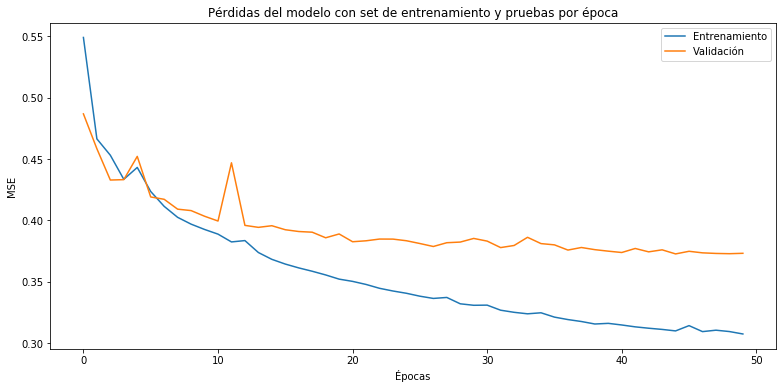

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(13,6))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title("Pérdidas del modelo con set de entrenamiento y pruebas por época")
plt.ylabel('MSE')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

Trata de realizar predicciones con el modelo

In [0]:
real=pd.DataFrame(y_train)
predic=model.predict(pd.DataFrame(x_train_scaled))
valores_reescalados = scaler1.inverse_transform(predic)
pred_escal =pd.DataFrame(valores_reescalados)
# Muestra los valores reales y las predicciones
for i in range(0,5):
	print("Real=%s, Prediccion=%s" % (real[0][i], pred_escal[0][i]))

Real=18650, Prediccion=17206.432
Real=9950, Prediccion=8765.462
Real=2000, Prediccion=2758.144
Real=7999, Prediccion=6074.4414
Real=23999, Prediccion=24185.717


# Happy coding!